# Make requests to the Best Buy API

https://bestbuyapis.github.io/api-documentation/

https://developer.bestbuy.com/secure/dashboard

# Imports

In [188]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
today = str(datetime.date.today())
print(today)

2019-04-24


In [ ]:
session = requests.Session()

# Load the API key

In [ ]:
# Load the API key
with open("./.bestbuy_api_key.txt") as fi:
    api_key = fi.read().split(": ", 1)[-1].strip()

# Search for flat screen 4K TVs

In [3]:
def assemble_request(search_term, **kwargs):   
    s = ""
    for key, value in params.items():
        s += f"&{key}={value}"
    url = f"https://api.bestbuy.com/v1/products((search={search_term.replace(' ', '%20')})&(categoryPath.id=abcat0101000))?apiKey={api_key}&format=json" + s
    return url

In [4]:
fields = 'name,regularPrice,screenSizeIn,sku'
products = pd.DataFrame(columns=fields.split(','))
search_term = "4K"
for page_num in range(1, 20):
    params = {'page': page_num,
              'pageSize': 50,
              'show': fields}
    url = assemble_request(search_term, **params)

    # Make the request
    r = session.get(url)
    assert r.status_code == 200, f"Bad response: {r.status_code}"
    tmp = pd.DataFrame(r.json()['products'])
    print(f"Found {len(tmp)} product results")
    if not len(tmp):
        break
    products = pd.concat([products, tmp])
    time.sleep(5)

# Remove duplicates and set index to the SKU number
products.drop_duplicates(subset=['sku'], inplace=True)
products.set_index('sku', inplace=True)

Found 50 product results
Found 50 product results
Found 50 product results
Found 25 product results
Found 0 product results


## Save the results as a pickle

In [45]:
products.to_pickle("4k_tv_prices.pickle")

# Load the saved results

In [8]:
products = pd.read_pickle("4k_tv_prices.pickle")

# Most expensive TV?

In [243]:
products.loc[[products.regularPrice.idxmax()]]

,sku,name,regularPrice,screenSizeIn
147,5762018,"Samsung - 88"" Class - LED - Q9F Series - 2160p...",19999.99,88.0


# Start making graphs

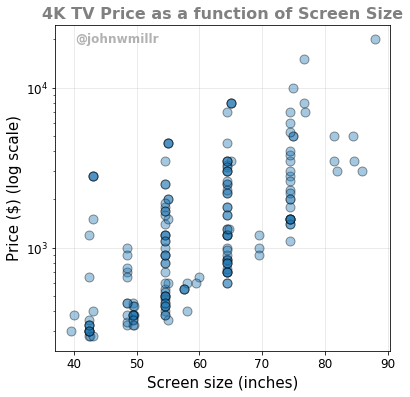

In [9]:
plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.4, 'fontsize': 12, 'figsize': (6, 6), 'markeredgecolor': 'k', 'legend': False}
products.plot(y='regularPrice', x='screenSizeIn', logy=True, **plot_dict)
plt.xlabel("Screen size (inches)", fontsize=15)
plt.ylabel("Price ($) (log scale)", fontsize=15)
plt.title("4K TV Price as a function of Screen Size", fontsize=16, color="gray", weight="heavy", loc='center')
plt.grid(True, axis='both', alpha=0.3)
plt.text(40.3, 19.2e3, "@johnwmillr", ha="left", fontsize=12, color='gray', weight='heavy', alpha=0.6)
plt.show()
# plt.savefig("./price_vs_size_logy.png", dpi=300, bbox_inches='tight')

# Fit an exponential curve to the plot

In [10]:
from scipy.optimize import curve_fit

In [11]:
def exponenial_func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [12]:
x = products['screenSizeIn']
y = products['regularPrice']
popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))

In [13]:
xx = np.linspace(1, 100, 500)
yy = exponenial_func(xx, *popt)

## Graph price as a function of screen size

In [235]:
def make_tv_graph(logy=False, savefig=False):
    plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.3,
                 'fontsize': 12, 'figsize': (8, 6),
                 'markeredgecolor': 'k', 'legend': False}

    # Make the figure and plot
    fig, ax = plt.subplots()
    products.plot(y='regularPrice', x='screenSizeIn', ax=ax, **plot_dict, logy=logy)
    ax.plot(xx, yy, 'r', lw=5, alpha=0.3) # Curve fit

    # Touch up the plot
    ax.set_xlim([35, 95])
    ax.set_xlabel("Screen size (inches)", fontsize=15)
    ax.grid(True, axis='both', alpha=0.4)
    
    if not logy:
        ax.set_ylim([-500, 21e3])
        ax.set_yticks(range(0, int(20.1e3), 2500))
    else:
        ax.set_ylabel("Price ($) (Log scale)", fontsize=15)
        
    ylabels = list(map(lambda s: f"${s:,.2f}".replace(",000.00", ".0k").replace(",500.00", ".5k"), ax.get_yticks()))
    ax.set_yticklabels(ylabels)    

    # Add a title and text
    x = 32 if logy else 28.8
    y = 40e3 if logy else 21.5e3
    ax.text(x, y, "4K TV Price as a function of screen size",
            fontsize=21 if logy else 22.2, color="gray", weight="heavy", ha='left', alpha=0.9)

    # @johnwmillr
    y = 0.25e3 if logy else 0.2e3
    ax.text(92.7, y, "@ johnwmillr", ha="left",
            fontsize=12, color='gray', weight='heavy',
            alpha=0.7, rotation=90, va='bottom')

    # Save the figure?
    if savefig:
        plt.savefig(f"./figures/price_vs_size_{'log' if logy else 'linear'}_{today}.png", dpi=300, bbox_inches='tight')
    plt.show()

## Linear plot

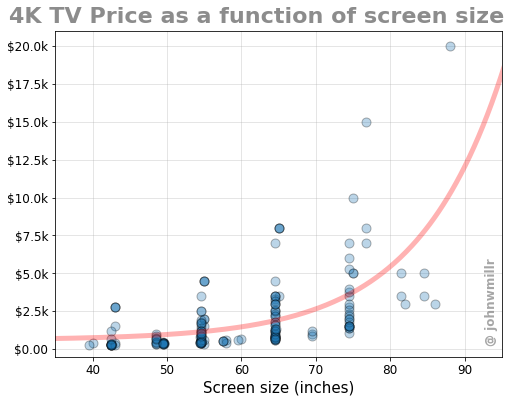

In [237]:
make_tv_graph(logy=False, savefig=True)

## Log plot

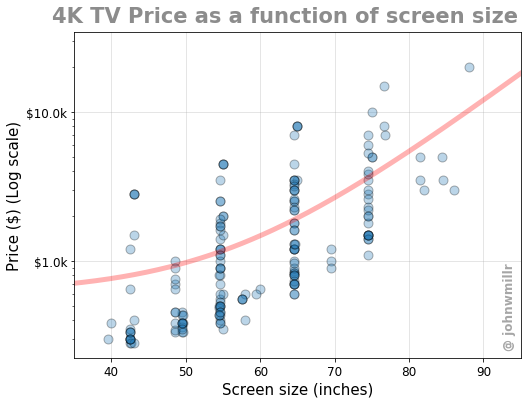

In [238]:
make_tv_graph(logy=True, savefig=True)

## Combo plot

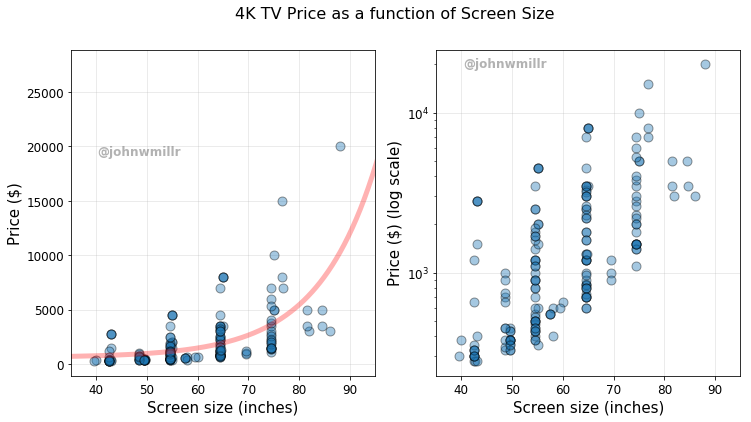

In [33]:
plot_dict = {'style': 'o', 'ms': 9, 'alpha': 0.4, 'fontsize': 12, 'figsize': (12, 6), 'markeredgecolor': 'k', 'legend': False}

logs = [False, True]
fig, axs = plt.subplots(ncols=2)
for ax, logy in zip(axs, logs):
    products.plot(y='regularPrice', x='screenSizeIn', logy=logy, **plot_dict, ax=ax, sharex=True)
    if not logy:
        ax.plot(xx, yy, 'r', lw=5, alpha=0.3)
    ax.set_xlim([35, 95])
    ax.set_xlabel("Screen size (inches)", fontsize=15)
    ax.set_ylabel(f"Price ($){' (log scale)' if logy else ''}", fontsize=15)
    ax.grid(True, axis='both', alpha=0.3)
    ax.text(40.3, 19.2e3, "@johnwmillr", ha="left", fontsize=12, color='gray', weight='heavy', alpha=0.6)
# plt.suptitle("4K TV Price as a function of Screen Size", fontsize=16, color="gray", weight="heavy", loc='center')    
plt.suptitle("4K TV Price as a function of Screen Size", fontsize=16)
plt.show()
# plt.savefig("./price_vs_size_logy.png", dpi=300, bbox_inches='tight')